# Electroencephalogram (EEG) Analysis
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. A quick EEG primer
2. A dash through EEG preprocessing
3. Single-subject ERP analysis


## EEG System

![ActiCHamp](https://www.brainproducts.com/wp-content/uploads/2020/12/PDP_actiCHamp-Plus_actiCAP.jpg)


# Quick EEG primer

![da Silva (2004)](https://ars.els-cdn.com/content/image/1-s2.0-S0730725X04003054-gr1.jpg)
(From da Silva, 2004, *Magnetic Resonance Imaging*)

## No neuroimaging modality is perfect...

... Trading off spatial and temporal resolution.

![Neuroimaging Modalities](http://2.bp.blogspot.com/-etqPHV_xz9s/VVZdaFj0WLI/AAAAAAAAFfQ/i_3DrkZ0wrY/s1600/fig6.jpg)

(From Sejnowski, Churchland and Movshon, 2014, *Nature Neuroscience*)

# MNE for EEG/MEG analysis in Python

![](https://mne.tools/stable/_images/mne_logo_dark.svg)

You're going to need some new libraries for processing EEG data:

```bash
conda install -c conda-forge mne

or

python -m pip install mne[hdf5]
```
and also:
```bash
python -m pip install pyyaml

```


In [1]:
# import some useful libraries
%matplotlib inline

import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import os
import yaml

# import mne stuff
import mne

## Load in the data

In [2]:
# load the raw data
raw = mne.io.read_raw_brainvision('rof07_odd.vhdr')

# add the electrode montage info
digmontage = mne.channels.make_standard_montage('brainproducts-RNP-BA-128')
raw.set_montage(digmontage)

Extracting parameters from rof07_odd.vhdr...
Setting channel info structure...


<RawBrainVision | rof07_odd.eeg, 64 x 1066200 (1066.2 s), ~95 kB, data not loaded>

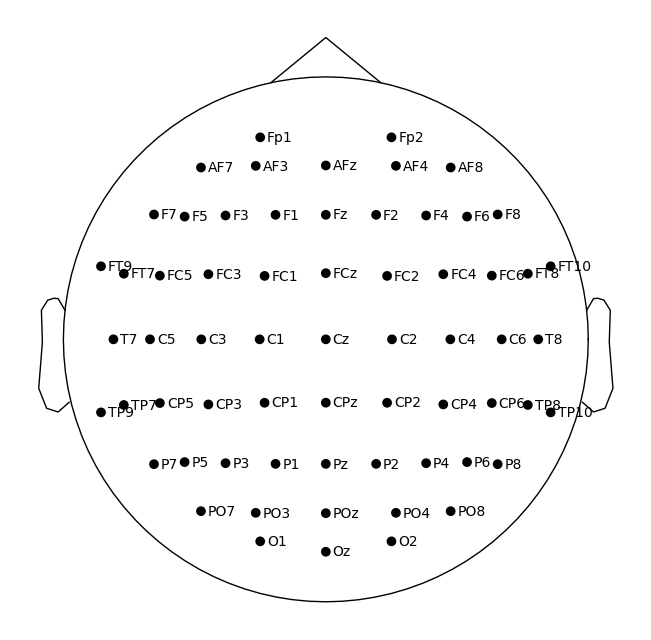

In [3]:
# plot the electrode locations
raw.get_montage().plot();

Effective window size : 2.048 (s)


/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


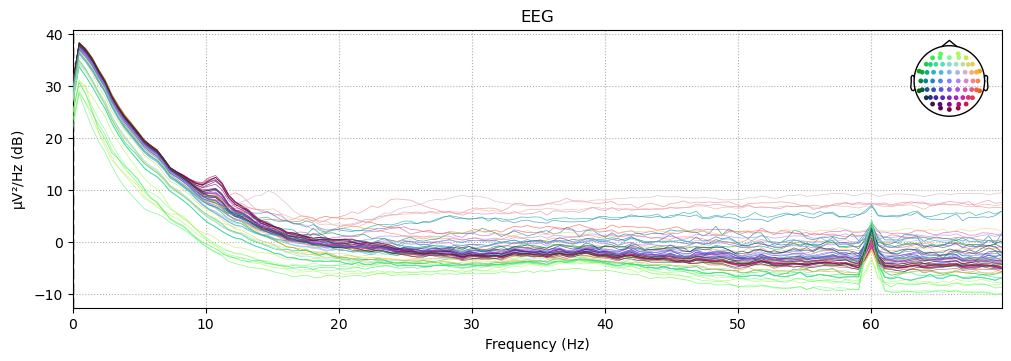

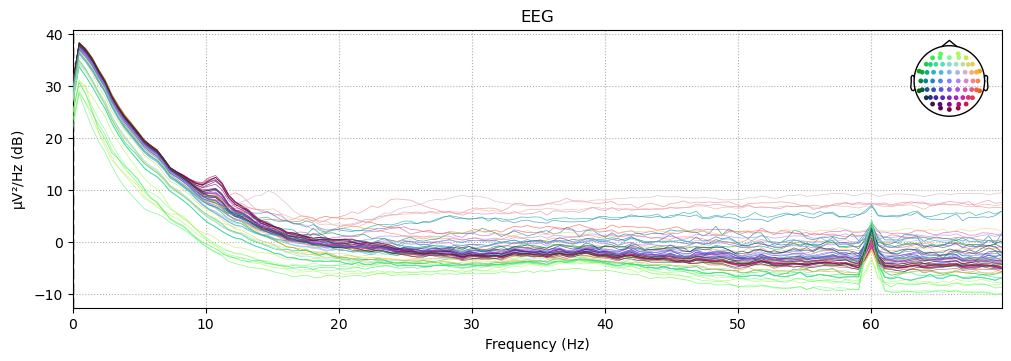

In [4]:
raw.compute_psd(fmax=70).plot(picks="data", exclude="bads")


In [5]:
# load in the events
with open('rof07_odd/exp.yaml', 'r') as file:
    events = yaml.safe_load(file)

# fix the stim_on time
for i in range(len(events)):
    events[i]['stim_on'] = events[i]['stim_on']['time']
    press_time = events[i]['press_time']
    if press_time:
        events[i]['press_time'] = press_time['time']
        events[i]['press_error'] = press_time['error']
    
# convert to pandas dataframe
events = pd.DataFrame(events)
events.tail()

common_resp common_stim    cond  correct correct_resp modality  \
395           J           O  common     True            J   visual   
396           J           O  common     True            J   visual   
397           J           O    rare     True            F   visual   
398           J           O    rare     True            F   visual   
399           J           O  common     True            J   visual   

       press_time rare_resp rare_stim response        rt stim       stim_on  \
395  1.443469e+09         F         X        J  0.323669    O  1.443469e+09   
396  1.443469e+09         F         X        J  0.338588    O  1.443469e+09   
397  1.443469e+09         F         X        F  0.464264    X  1.443469e+09   
398  1.443469e+09         F         X        F  0.321332    X  1.443469e+09   
399  1.443469e+09         F         X        J  0.373990    O  1.443469e+09   

     press_error  
395     0.000043  
396     0.000041  
397     0.000282  
398     0.000290  
399     0.000194

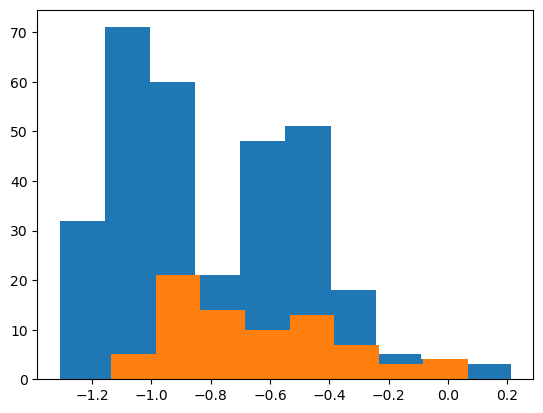

In [6]:
plt.hist(np.log(events.loc[events['cond']=='common', 'rt']), bins='auto');
plt.hist(np.log(events.loc[events['cond']=='rare', 'rt']), bins='auto');

## Aligning behavior and EEG

- The EEG and Behavior are collected on different machines with different internal clocks
- EEG are stored in samples (per second), while experiment information (presentation times and responses) are stored in seconds
- It is necessary to align them to be able to analyze EEG a times matching the experiment conditions of interest

In [7]:
# load in the EEG pulse info
with open('rof07_odd/pulse.yaml', 'r') as file:
    beh_times = yaml.safe_load(file)
    
# fix the pulse times
for i in range(len(beh_times)):
    beh_times[i]['pulse_start'] = beh_times[i]['pulse_start']['time']
    beh_times[i]['pulse_end'] = beh_times[i]['pulse_end']['time']

# convert to dataframe
beh_times = pd.DataFrame(beh_times)
beh_times.tail()

pulse_code     pulse_end   pulse_start
432          15  1.443469e+09  1.443469e+09
433          15  1.443469e+09  1.443469e+09
434          15  1.443469e+09  1.443469e+09
435          15  1.443469e+09  1.443469e+09
436          15  1.443469e+09  1.443469e+09

In [8]:
# grab the eeg samples when the pulses came through
eeg_times = mne.events_from_annotations(raw)[0]
eeg_times = eeg_times[eeg_times[:, 2]==15, 0]
eeg_times[:10]

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 15']


array([ 2124,  5083,  8586, 11943, 14031, 16853, 19440, 22641, 26085,
       29568])

In [9]:
# helper function to align EEG and Behavior
def times_to_offsets(eeg_times, beh_times, ev_times, blen=10, tolerance=.0015):
    """
    Fit line to EEG pulse times and behavioral pulse times and apply to event times.

    """
    start_ind = None
    # get starting ind for the beh_times
    for i in range(len(beh_times)//2):
        if np.abs(np.diff(eeg_times[:blen]) - 
                  np.diff(beh_times[i:blen+i])).sum()<(tolerance*blen):
            start_ind = i
            break
    if start_ind is None:
        raise ValueError('No starting point found')

    # iterate, making sure each diff is within tolerance
    etimes = []
    btimes = []
    j = 0
    for i, bt in enumerate(beh_times[start_ind:]):
        if (i == 0) or (np.abs((bt-btimes[-1])-(eeg_times[j]-etimes[-1]))<(tolerance)):
            # looks good, so append
            etimes.append(eeg_times[j])
            btimes.append(bt)
            # increment eeg times counter
            j += 1
            #print i,
        else:
            # no good, so say we're skipping
            print('.', end=''), #(np.abs((bt-btimes[-1])-(eeg_times[j]-etimes[-1]))),
    print()
    # convert to arrays
    etimes = np.array(etimes)
    btimes = np.array(btimes)
    print("Num. matching: ", len(etimes)) #,len(btimes)
    plt.plot(np.diff(etimes), lw=5)
    plt.plot(np.diff(btimes))

    # fit a line to convert between behavioral and eeg times
    A = np.vstack([btimes, np.ones(len(btimes))]).T
    m, c = np.linalg.lstsq(A, etimes, rcond=None)[0]
    print("Slope and Offset: ", m ,c)

    # convert to get eoffsets
    eoffsets = ev_times*m + c

    return eoffsets


..................................................................................................................................................................................................................................................
Num. matching:  110
Slope and Offset:  0.9999485421849684 -253.19144659970257


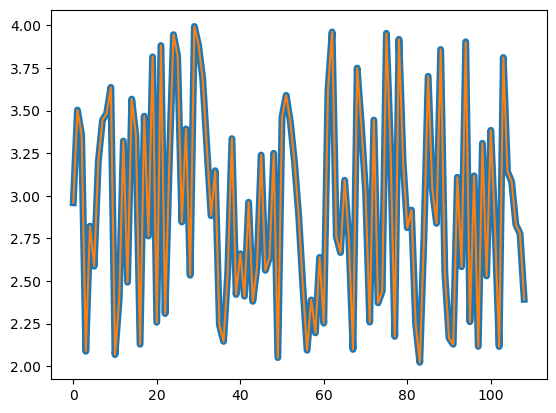

In [10]:
# convert the registered eeg pulse samples to seconds
etimes = eeg_times/raw.info['sfreq']

# grab the start of each pulse
btimes = np.array(beh_times['pulse_start'])

# zero the pulse times due to large values
offset = btimes[0]
btimes -= offset

# extract the stimulus times we want to convert to samples
ev_times = np.array(events['stim_on'])

# apply the same offset to these event times
ev_times -= offset

# perform the alignment and convert to samples
ev_samps = np.int32(np.round(times_to_offsets(etimes, btimes, ev_times)*raw.info['sfreq']))

# add the event samples to the events dataframe
events['ev_samp'] = ev_samps

## Process the raw EEG data

- EEG data are noisy, filled with eyeblinks and other movement artifacts, as well as line noise from electrical interference
- Most preprocessing attempts to mitigate this noise as much as possible

### Removing eyeblinks

- Eyeblinks cause a large artifact in the signal
- One approach is to toss any event of interest with an eyeblink in it, but that can end up removing too much data
- Here we'll use an independent component analysis (ICA) to remove eyeblinks

In [11]:
# we first high-pass filter the data at 1 Hz to remove slow drift 
filt_raw = raw.load_data().copy().filter(l_freq=1.0, h_freq=None)

Reading 0 ... 1066199  =      0.000 ...  1066.199 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Text(0, 0.5, 'Voltage (uV)')

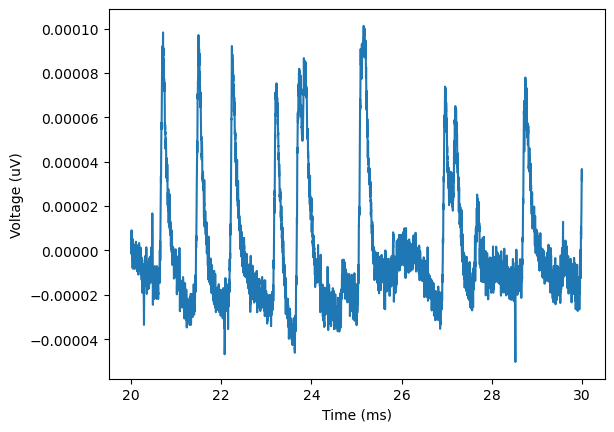

In [12]:
data, times = filt_raw.get_data(picks=['Fp1'], tmin=20, tmax=30, return_times=True)
plt.plot(times, data.T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')

In [13]:
# then we apply ICA 
ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", 
                            random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 31.2s.


<ICA | raw data decomposition, method: fastica (fit in 15 iterations on 1066200 samples), 15 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

In [14]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.9840718071984824


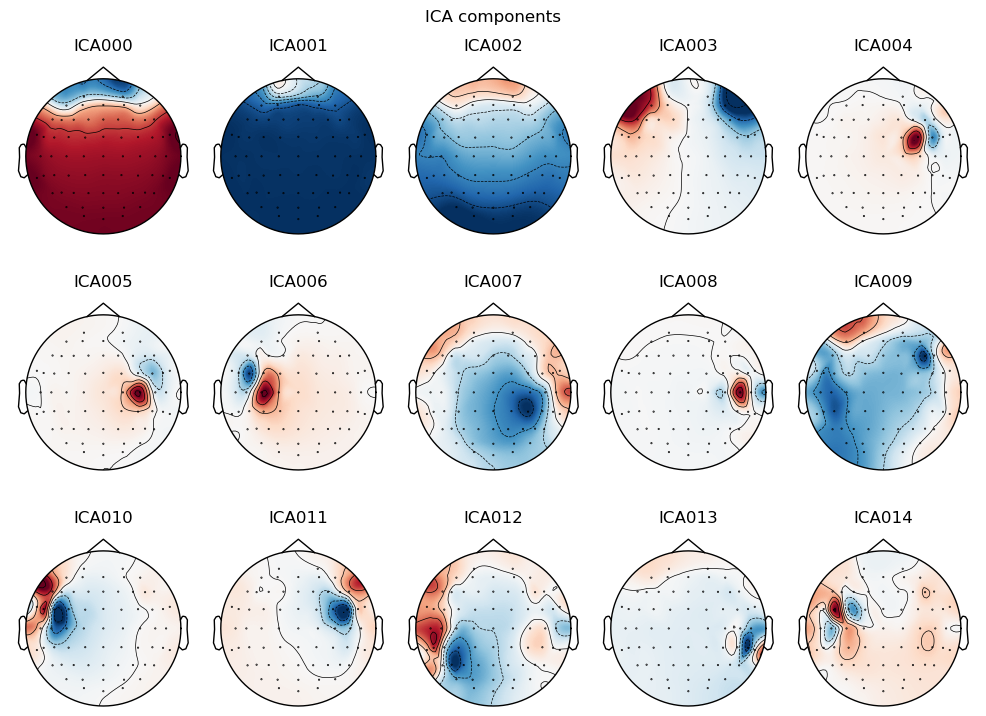

In [15]:
ica.plot_components();

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
533 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
533 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
533 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
533 matching events found
No baseline correction applied
0 projection items activated


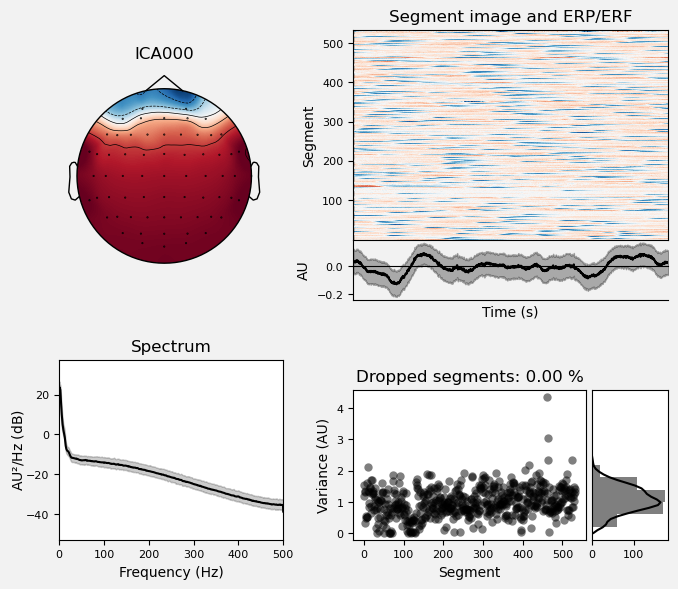

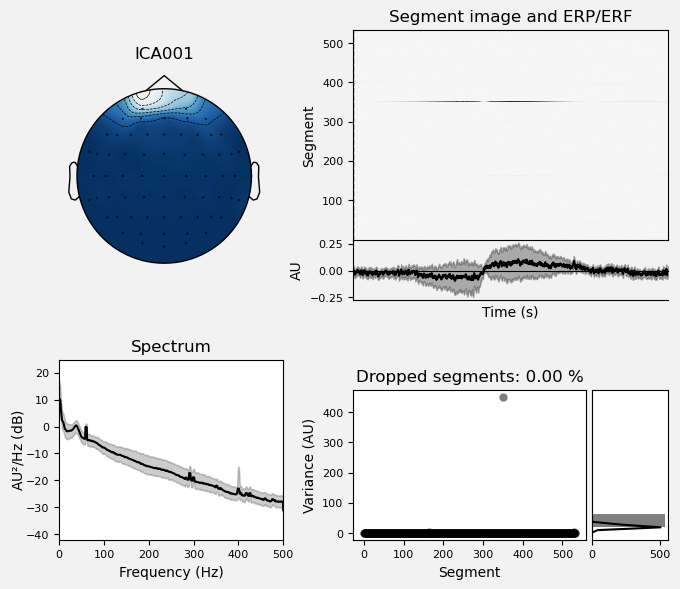

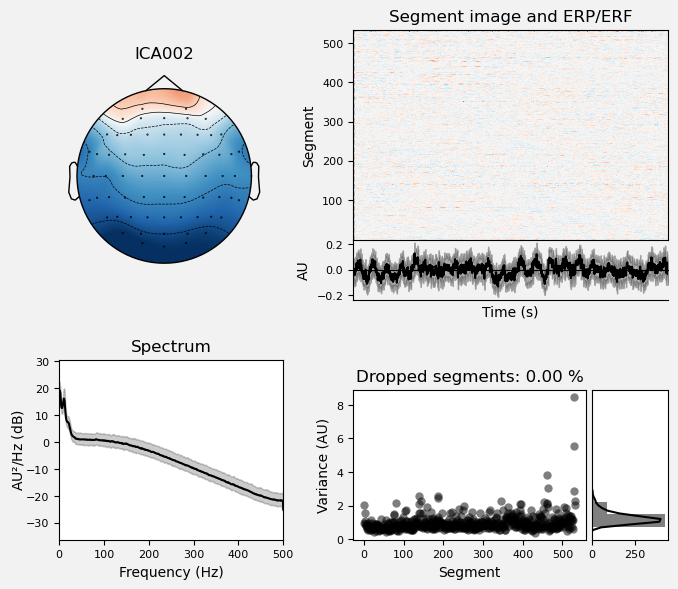

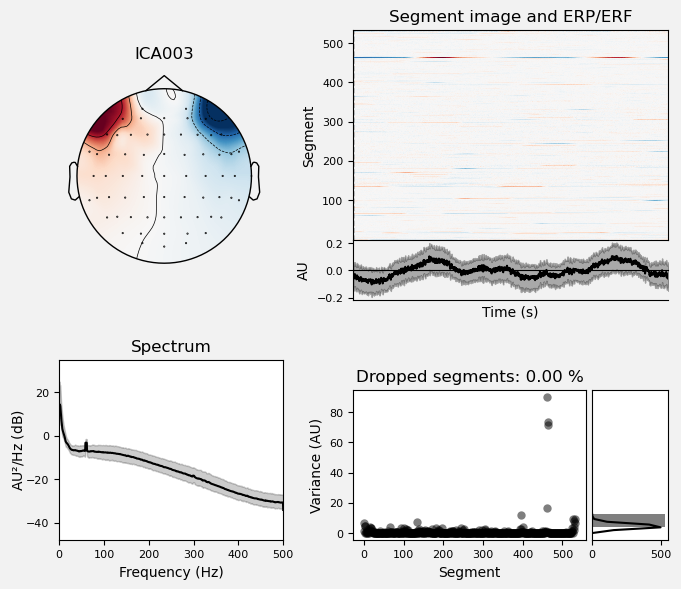

In [16]:
ica.plot_properties(filt_raw, picks=[0, 1, 2, 3]);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
533 matching events found
No baseline correction applied
0 projection items activated


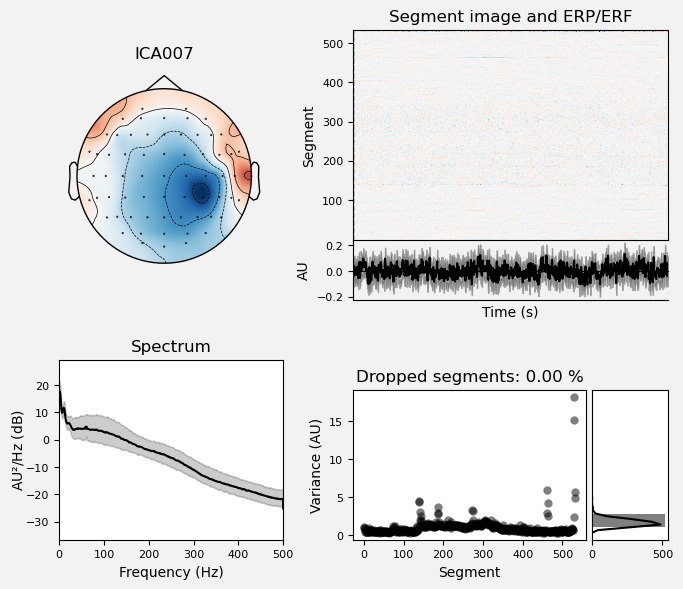

In [17]:
# What does a "good" component look like?
ica.plot_properties(filt_raw, picks=[7]);

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


Text(0, 0.5, 'Voltage (uV)')

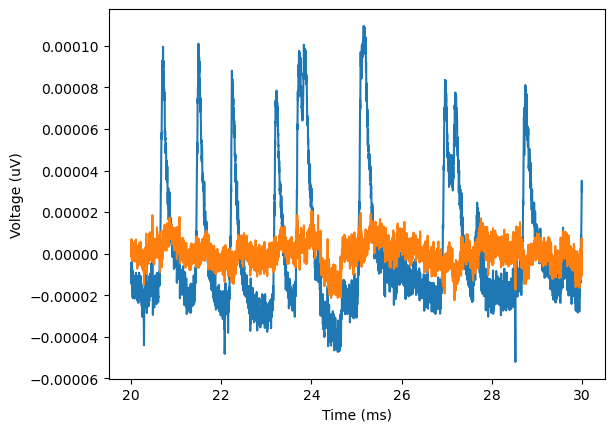

In [18]:
# let's remove the suspect signals
ica.exclude = [0, 1, 2, 3]
orig_raw = raw.copy()

# this time apply a .5 Hz high-pass
filt_raw = raw.load_data().copy().filter(l_freq=0.5, h_freq=None)

data, times = filt_raw.get_data(picks=['Fp1'], tmin=20, tmax=30, return_times=True)
plt.plot(times, data.T)

# apply the ICA with the excluded signals
ica.apply(filt_raw)

data, times = filt_raw.get_data(picks=['Fp1'], tmin=20, tmax=30, return_times=True)
plt.plot(times, data.T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')



Using matplotlib as 2D backend.


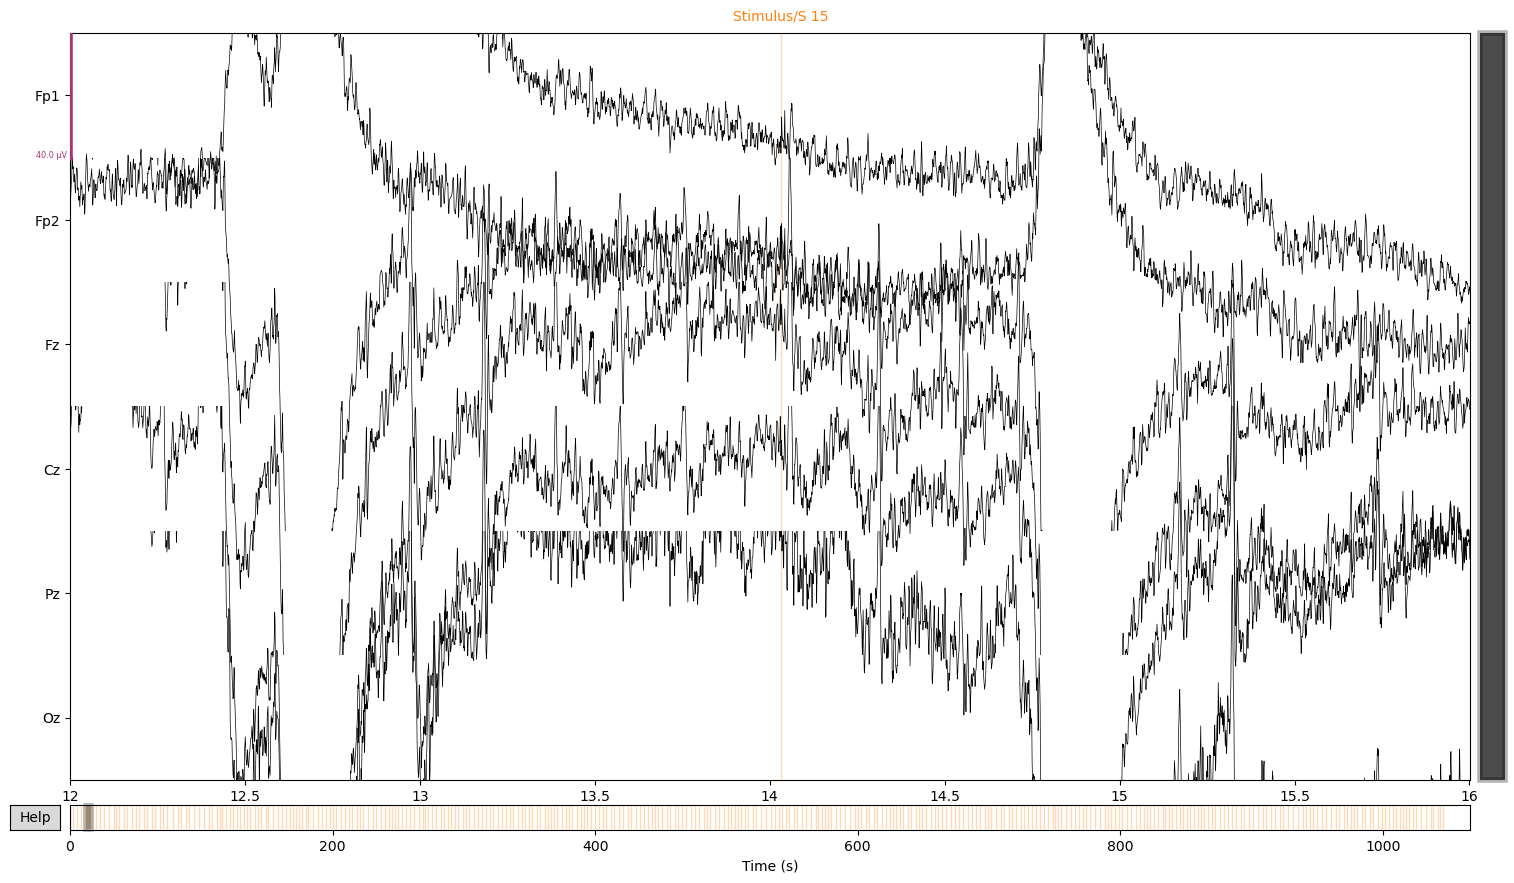

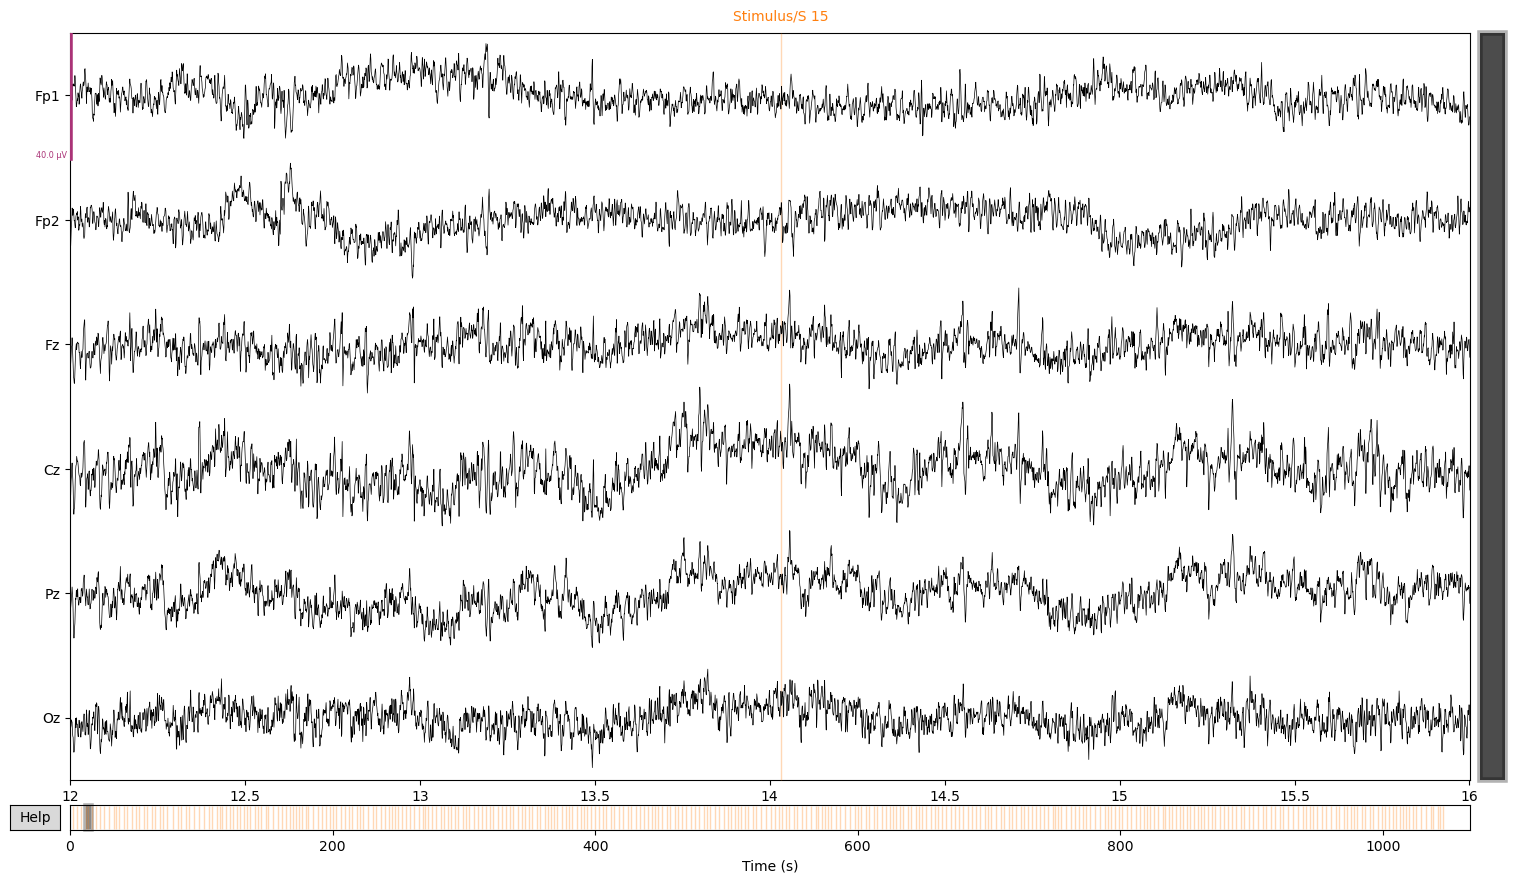

In [19]:
chs = ['Fp1', 'Fp2', 'Fz', 'Cz', 'Pz', 'Oz']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
filt_raw.plot(order=chan_idxs, start=12, duration=4);

## Extract Events/Epochs from the continuous data

In [20]:
# set event ids to zero
events['ev_id'] = 0
event_dict = {}
id_count = 0
for m in events['modality'].unique():
    for c in events['cond'].unique():
        # increment the counter
        id_count += 1
        
        # add the combo id to the dict
        event_dict['%s/%s'%(m,c)] = id_count
        
        # set the values for matching events
        row_ind = (events['modality']==m) & (events['cond']==c)
        events.loc[row_ind, 'ev_id'] = id_count
event_dict


{'auditory/common': 1,
 'auditory/rare': 2,
 'visual/common': 3,
 'visual/rare': 4}

In [21]:
# create events array
ev_array = np.vstack([events['ev_samp'], 
                      np.zeros(len(events), dtype=np.int32), 
                      events['ev_id']]).T
ev_array

array([[  17722,       0,       1],
       [  20717,       0,       1],
       [  23752,       0,       1],
       ...,
       [1038177,       0,       4],
       [1040536,       0,       4],
       [1042819,       0,       3]])

In [37]:
# set a rejection criterion
reject_criteria = dict(
    eeg=500e-6,  # 150 µV
    )

# add a lowpass filter (at 40Hz) 
epochs = mne.Epochs(
    filt_raw.copy().filter(l_freq=None, h_freq=40),
    ev_array,
    event_id=event_dict,
    tmin=-0.2,
    tmax=1.0,
    reject=reject_criteria,
    preload=True,
)
epochs

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Not setting metadata
400 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 1201 original time points ...
0 bad epochs dropped


<Epochs |  400 events (all good), -0.2 – 1 s, baseline -0.2 – 0 s, ~234.7 MB, data loaded,
 'auditory/common': 160
 'auditory/rare': 40
 'visual/common': 160
 'visual/rare': 40>

In [38]:
# resample to 200 Hz
epochs = epochs.resample(200)

In [39]:
# save the epochs out to file
epochs.save('rof07_odd-epo.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


## Compare Conditions

- Our primary question is whether there are differences in the neural response between common and rare stimuli (i.e., the oddball effect)
- We also can explore differences in modality (auditory vs. visual stimuli)

In [44]:
# we can average all the events for a particular condition
r_evoked = epochs['rare'].average()
c_evoked = epochs['common'].average()

No projector specified for this dataset. Please consider the method self.add_proj.


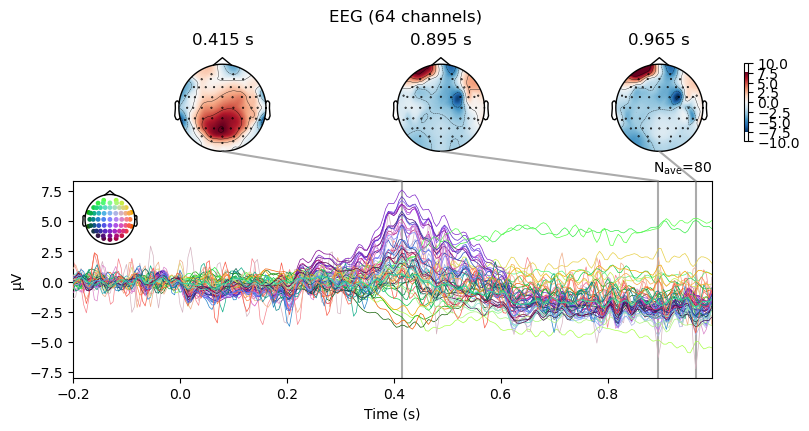

No projector specified for this dataset. Please consider the method self.add_proj.


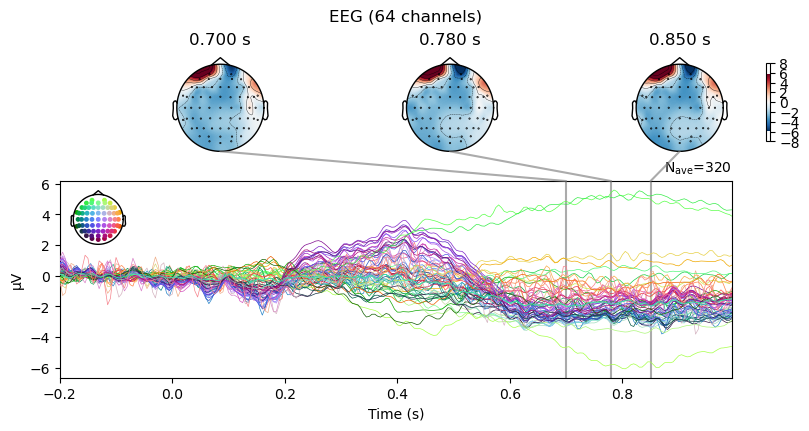

In [46]:
# and then plot all the event-related potentials (ERPs)
r_evoked.plot_joint();
c_evoked.plot_joint();

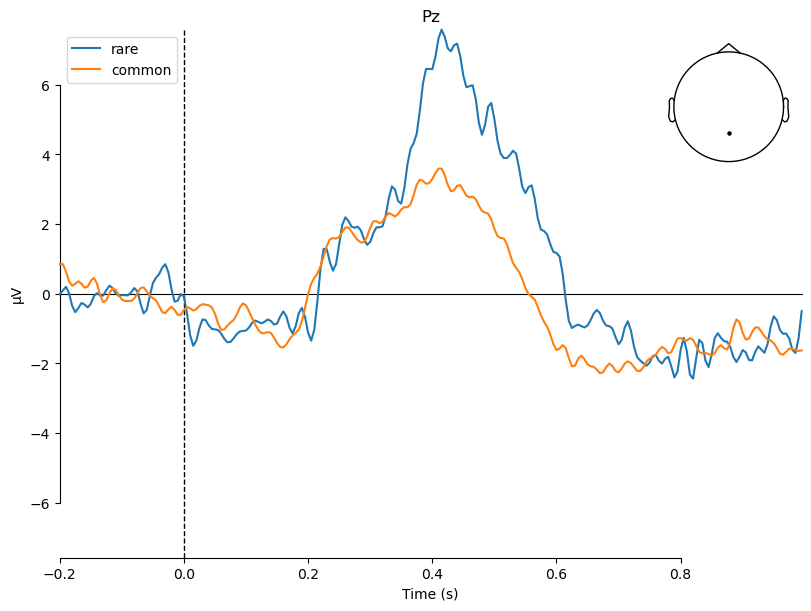

[<Figure size 800x600 with 2 Axes>]

In [47]:
# it looks like all the action is happening at electrode Pz
mne.viz.plot_compare_evokeds(
    dict(rare=r_evoked, common=c_evoked),
    legend="upper left",
    show_sensors="upper right",
    picks=['Pz'],
)

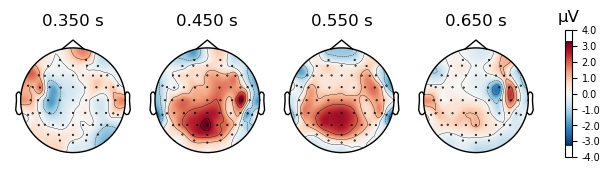

In [52]:
evoked_diff = mne.combine_evoked([r_evoked, c_evoked], weights=[1, -1])
evoked_diff.plot_topomap(times=[.35, .45, .55, .65]);

## Is it significant at that time range and electrode?

- Typically we would perform statistical tests at all electrodes and times, correcting for multiple comparisons (See Professor Long's EEG course!!!)
- Here we'll just perform a t-test at that time range and electrode

In [60]:
# grab the rare and common vals in the time range between .4 and .5 seconds
rare_vals = epochs['rare'].get_data(picks=['Pz'], tmin=.4, tmax=.5).mean(2)[:,0]
common_vals = epochs['common'].get_data(picks=['Pz'], tmin=.4, tmax=.5).mean(2)[:,0]

stats.ttest_ind(rare_vals, common_vals)

TtestResult(statistic=3.4026087423648463, pvalue=0.0007351328330206161, df=398.0)

- The rare events have significantly higher voltage values relative to common events at the time range between 0.4 and 0.5 seconds following stimulus onset at electrode Pz.

## Oddball EEG Summary

- We see a pretty robust oddball effect at posterior central electrodes at around 400ms post stimulus.
- Once again, this was just a single-subject analysis. Statistics calculated across subjects would be required to assess significance.

# Assignments and Final Project

- We'll post two small assignments:
  - MRI connectivity analysis
  - EEG analysis of visual vs. auditory
- We'll also post the instructions for the final project
- Remainder of assignment points will be awarded in full
- We will hold normal office hours on Monday and Tuesday next week
- We will *also* hold office hours during what would be the entire class time on Thursday
- Good luck on your final projects and have a great winter break!